# Используем препроцессинг с прошлых лаб..

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('telco.csv')
data.drop(['customerID'],axis=1,inplace=True)

categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
for column in categorical_columns:
    data[column] = data[column].astype('category')

data['gender']=data['gender'].replace('Male',1)
data['gender']=data['gender'].replace('Female',0)

yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for column in yes_no_columns:
    data[column]=data[column].replace('No',0)
    data[column]=data[column].replace('Yes',1)

binary_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',  'PaperlessBilling', 'Churn']

for column in binary_columns:
    data[column] = data[column].astype('bool')

data['TotalCharges'] = data['TotalCharges'].replace(r'\s+', np.nan, regex=True)
data['TotalCharges'] = data['TotalCharges'].astype('float64')

data.dropna(inplace=True)
data = pd.get_dummies(data, categorical_columns)


X = data.drop(['Churn'], axis=1)
y = data['Churn']

### Построим кластеризатор на основе KMeans

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init= 10, random_state=0, max_iter=800).fit(X)
print(f'Accuracy is {np.sum(y == kmeans.labels_)/y.shape[0]}')

Accuracy is 0.5282992036405005


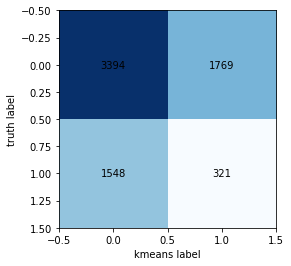

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, kmeans.labels_)

plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()



Точность оказалась не такой высокой, как хотелось бы. В целом это может быть обусловлено низкой зависимостью между параметрами

### Попробуем построить DBSCAN

In [67]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN().fit(X)
print(f'Labels {np.unique(dbscan.labels_)}')
print(f'Accuracy is {np.sum(y == dbscan.labels_)/y.shape[0]}')

Labels [   0    1    2 ... 6843 6844 6845]
Accuracy is 0.0001422070534698521


Как и ожидалось, без параметров DBSCAN нашел другое количество классов, чем у нас имеется в изначальной выборке. Попробуем поиграться с параметрами

In [90]:
eps_vals = np.array([0.5, 1, 2, 10, 15, 20, 30, 40, 50, 60, 70, 100])
labels = []
accuracy = []
for eps in eps_vals:
    dbscan = DBSCAN(eps).fit(X)
    labels.append(np.unique(dbscan.labels_))
    accuracy.append(np.sum(y == dbscan.labels_)/y.shape[0])

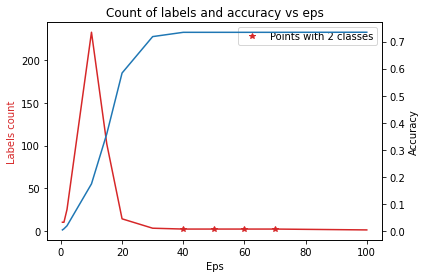

In [95]:
fig, ax1 = plt.subplots()

count_of_labels = np.array(list(map(len, labels)))
find_required = [i for i, count in enumerate(count_of_labels) if count == 2]

color = 'tab:red'
ax1.plot(eps_vals, count_of_labels, color=color)
ax1.plot(eps_vals[find_required], count_of_labels[find_required], '*', color=color, label='Points with 2 classes')
ax1.set_ylabel('Labels count', color= color)
ax1.set_xlabel('Eps')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(eps_vals, accuracy, color=color)
ax2.set_ylabel('Accuracy')

ax1.legend()
plt.title("Count of labels and accuracy vs eps")
plt.show()

С точки зрения точность в данном случае все намного лучше, можно достичь результата  вплоть до 70%. Странный скачок в начале графа можно объяснить захватом большего количества "одиночных" (выбросов) точек. Так как минимальное количество для кластера равно 5, то при данном значении eps резко появилось большое количество кластеров, достигших данного размера. Проверим теорию

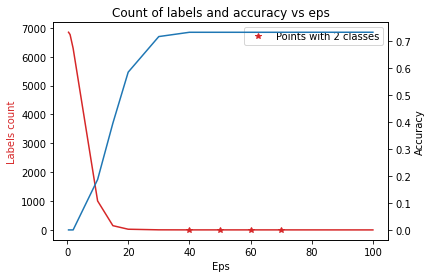

In [98]:
eps_vals = np.array([0.5, 1, 2, 10, 15, 20, 30, 40, 50, 60, 70, 100])
labels = []
accuracy = []
for eps in eps_vals:
    dbscan = DBSCAN(eps, min_samples=0).fit(X)
    labels.append(np.unique(dbscan.labels_))
    accuracy.append(np.sum(y == dbscan.labels_)/y.shape[0])

fig, ax1 = plt.subplots()

count_of_labels = np.array(list(map(len, labels)))
find_required = [i for i, count in enumerate(count_of_labels) if count == 2]

color = 'tab:red'
ax1.plot(eps_vals, count_of_labels, color=color)
ax1.plot(eps_vals[find_required], count_of_labels[find_required], '*', color=color, label='Points with 2 classes')
ax1.set_ylabel('Labels count', color= color)
ax1.set_xlabel('Eps')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(eps_vals, accuracy, color=color)
ax2.set_ylabel('Accuracy')

ax1.legend()
plt.title("Count of labels and accuracy vs eps")
plt.show()

Теория подтвердилась, в этот раз график более сглаженный. Отбросим первую часть, коогда количество кластеров очень большое

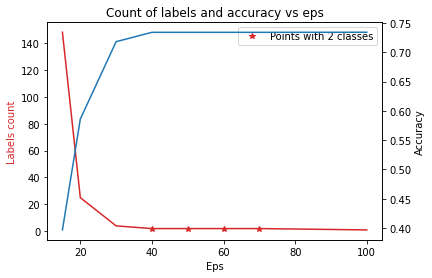

In [104]:
fig, ax1 = plt.subplots()

index = 4

color = 'tab:red'
ax1.plot(eps_vals[index:], count_of_labels[index:], color=color)
ax1.plot(eps_vals[find_required], count_of_labels[find_required], '*', color=color, label='Points with 2 classes')
ax1.set_ylabel('Labels count', color= color)
ax1.set_xlabel('Eps')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(eps_vals[index:], accuracy[index:], color=color)
ax2.set_ylabel('Accuracy')

ax1.legend()
plt.title("Count of labels and accuracy vs eps")
plt.show()

In [117]:
print("\n".join(map(str, enumerate(zip(count_of_labels, accuracy)))))

(0, (6846, 0.0001422070534698521))
(1, (6766, 0.0001422070534698521))
(2, (6289, 0.0001422070534698521))
(3, (1005, 0.18714448236632536))
(4, (148, 0.3967576791808874))
(5, (25, 0.5860352673492605))
(6, (4, 0.7181456200227532))
(7, (2, 0.7340728100113766))
(8, (2, 0.7340728100113766))
(9, (2, 0.7340728100113766))
(10, (2, 0.7340728100113766))
(11, (1, 0.7342150170648464))


В итоге имеем, что с помощью DBSCAN метода можно получить точность вплоть до 73.4 процентов, что оень очень хороший результат для данного датасета. Посмотрим вниматльнее, что получилось

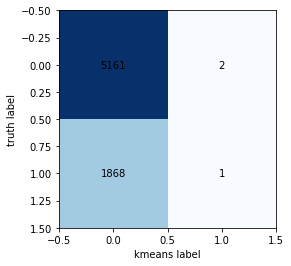

In [116]:
cm = confusion_matrix(y, DBSCAN(eps_vals[10], min_samples=0).fit(X).labels_)

plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

Очень интересный результат.. Похоже, наш DBSCan переобучился и попросту отнес все значения к первому классу, практически ничего не оставив на второй, а из-за несбалансированности классов получили высокую точность (первого класса попросту больше). попробуем вернуться к варианту, когда мы отбрасывали классы из-за недостаточного количества сэмплов внутри

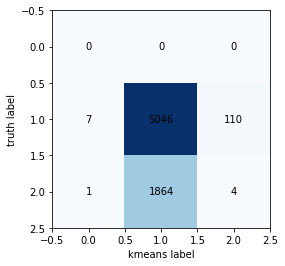

In [125]:
cm = confusion_matrix(y, DBSCAN(eps_vals[6]).fit(X).labels_)

plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

Попробуем заставить наш DBSCAN считать классы более правильно..

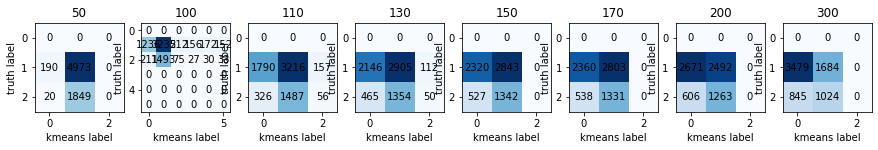

In [164]:
samples = [50, 100, 110, 130, 150, 170, 200, 300]
f, axes = plt.subplots(1, len(samples))
f.set_figheight(15)
f.set_figwidth(15)
for i, sample in enumerate(samples):
    cm = confusion_matrix(y, DBSCAN(90, min_samples=sample).fit(X).labels_)

    subplot = axes[i]
    subplot.imshow(cm,interpolation='none',cmap='Blues')
    for (i, j), z in np.ndenumerate(cm):
        subplot.text(j, i, z, ha='center', va='center')
    subplot.set_xlabel("kmeans label")
    subplot.set_ylabel("truth label")
    subplot.set_title(str(sample))
plt.show()

Попробуем кластеризатор Birch. Это некоторый подвид kmeans алгоритма

In [167]:
from sklearn.cluster import Birch
birch = Birch(n_clusters=2).fit(X)
print(f'Accuracy is {np.sum(y == birch.labels_)/y.shape[0]}')

Accuracy is 0.5376848691695109


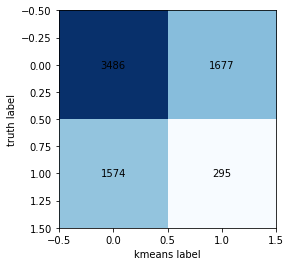

In [168]:
cm = confusion_matrix(y, birch.labels_)

plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()


В целом результат такой же, как для kmeans. попробуем поиграться с параметрами

In [171]:
threshold = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1]
accuracy = []
for th in threshold:
    birch = Birch(n_clusters=2, threshold=th).fit(X)
    accuracy.append(np.sum(y == birch.labels_)/y.shape[0])

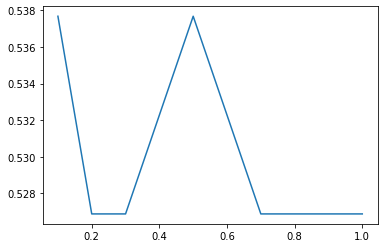

In [172]:
plt.plot(threshold, accuracy)

Похоже, что для данного кластеризатора лучших результатов получить не выйдет

# Итог
В итоге имеем, что классические алгоритмы кластеризации не способны правильно и хорошо кластеризовать данный датасет. Объяснить это можно тем, что изначально параметры плохо зависимы, целевая переменная плохо обусловленна и лучший результат достигается в случае "константного" кластеризатора (ввиду неоднородности классов)